# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.575838,True,7.133607
1,1.095211,True,6.366922
2,-0.661489,False,-1.577362
3,-1.110238,False,-0.777604
4,0.637061,True,8.335881
...,...,...,...
995,-0.961203,False,-1.837391
996,0.455153,True,4.324899
997,-1.525638,False,-1.654191
998,0.112964,True,5.480000


<Axes: xlabel='v0'>

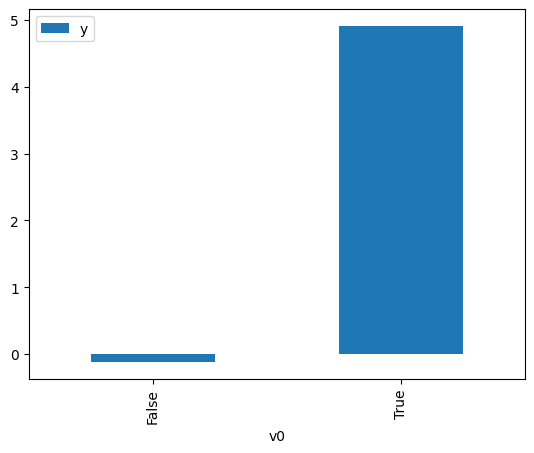

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

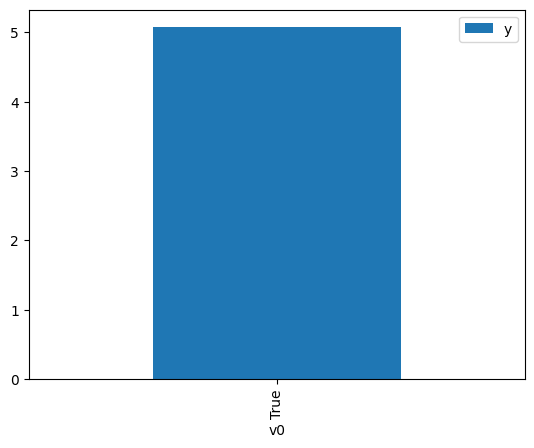

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.474157,False,-0.415061,0.775683,1.289187
1,0.105259,False,0.315129,0.457299,2.186752
2,0.052347,False,1.093853,0.489430,2.043192
3,-0.282519,False,0.404985,0.684322,1.461301
4,0.295598,False,1.069823,0.346370,2.887083
...,...,...,...,...,...
995,-0.361452,False,-0.299772,0.724331,1.380584
996,0.110862,False,0.339938,0.453913,2.203065
997,0.935836,False,0.059632,0.100187,9.981292
998,-0.130305,False,-0.417718,0.599359,1.668450


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.589762,True,4.315394,0.794430,1.258763
1,-1.451635,True,2.201894,0.026019,38.433648
2,0.439846,True,6.291601,0.728402,1.372868
3,-1.451635,True,2.201894,0.026019,38.433648
4,-0.183119,True,4.243337,0.370169,2.701466
...,...,...,...,...,...
995,-1.667584,True,3.431964,0.015538,64.357121
996,-0.638213,True,4.653457,0.162404,6.157484
997,-0.470002,True,4.724319,0.226084,4.423135
998,0.284855,True,5.069030,0.647679,1.543974


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              8498.
Date:                Fri, 10 Nov 2023   Prob (F-statistic):                        0.00
Time:                        04:48:40   Log-Likelihood:                         -1410.9
No. Observations:                1000   AIC:                                      2826.
Df Residuals:                     998   BIC:                                      2836.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2847      0.035     36.566      0.000       1.216       1.354
x2             4.9852      0.051     98.528      0.000       4.886       5.084
==============================================================================
Omnibus:                        1.943   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.874
Skew:                          -0.050   Prob(JB):                        0.392
Kurtosis:                       3.187   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""